In [53]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from tensorflow import keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, BatchNormalization, Flatten, Input, MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [55]:
sdir = '/content/drive/MyDrive/DATASET PARKINSON/'

filepaths = []
labels = []
classlist = os.listdir(sdir)
for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/DATASET PARKINSON/tremo...  tremor
1  /content/drive/MyDrive/DATASET PARKINSON/tremo...  tremor
2  /content/drive/MyDrive/DATASET PARKINSON/tremo...  tremor
3  /content/drive/MyDrive/DATASET PARKINSON/tremo...  tremor
4  /content/drive/MyDrive/DATASET PARKINSON/tremo...  tremor
tremor        510
non tremor    510
Name: labels, dtype: int64


In [56]:
# Looping untuk memproses setiap gambar
for index, row in df.iterrows():
    file_path = row['filepaths']
    label = row['labels']

    # Baca gambar
    img = cv2.imread(file_path)
    if img is None:
        print("File tidak ditemukan:", file_path)
        continue  # Lewatkan gambar jika tidak dapat dibaca

    # Lakukan preprocessing menggunakan OpenCV
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.erode(gray, kernel, iterations=1)
    _, imfill = cv2.threshold(edges, 220, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    imgResize = cv2.resize(imfill, (224, 224))

    # Simpan gambar yang sudah di-preprocess kembali ke lokasi yang sama
    cv2.imwrite(file_path, imgResize)

In [57]:
train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))

train_df length: 816 test_df length: 102 valid_df length: 102


In [58]:
# Menentukan dimensi gambar (tinggi, lebar, dan saluran warna)
height = 224
width = 224
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

gen = ImageDataGenerator(
    rescale=1./255
    )
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                          color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

test batch size: 51 test steps: 2
Found 816 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.
['non tremor', 'tremor']


In [59]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    imgResize, labels = next(gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = imgResize[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

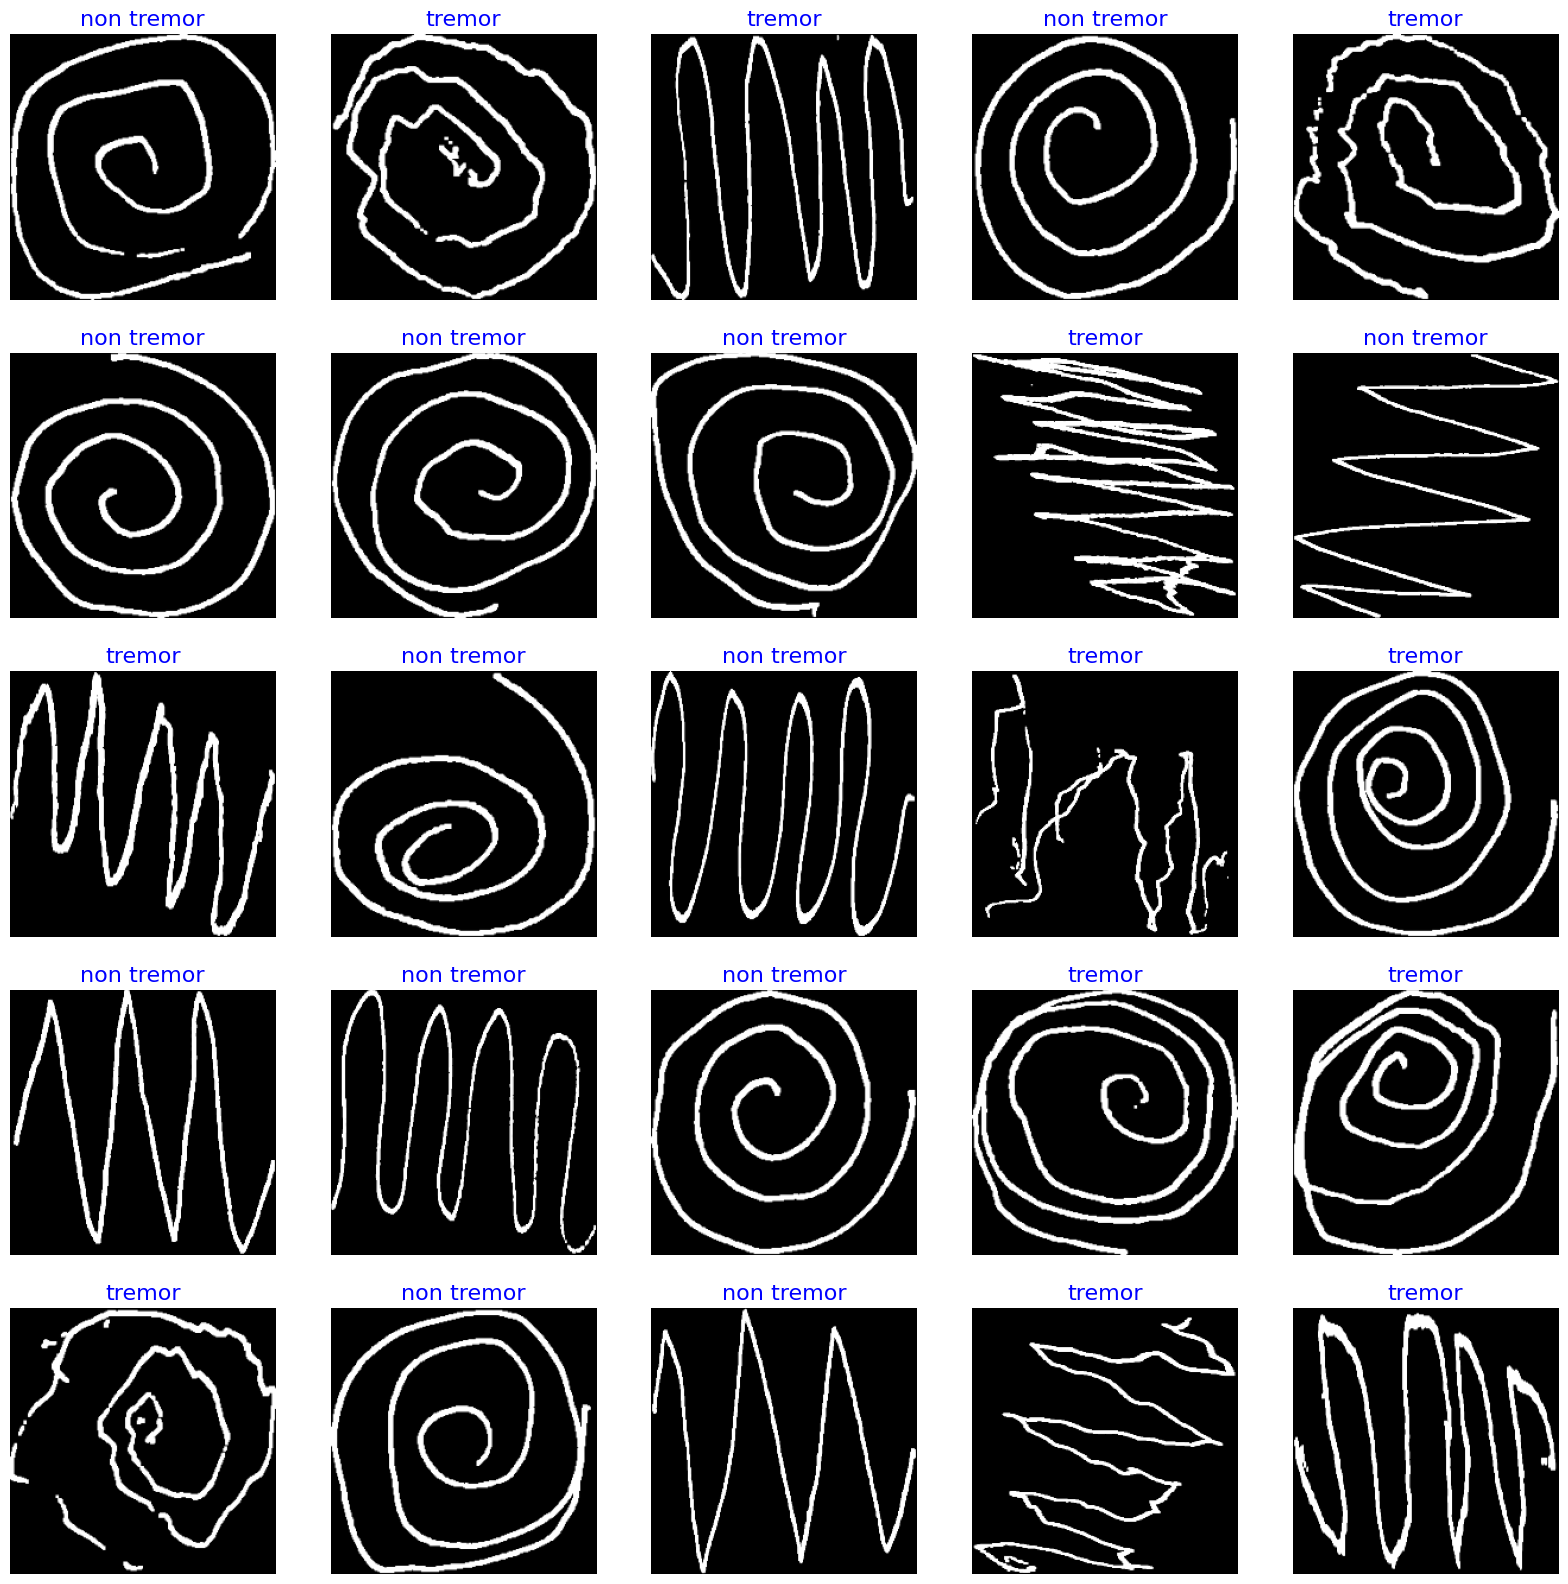

In [60]:
show_image_samples(train_gen)

In [61]:
# Import DenseNet169 sebagai model dasar
base_model = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet', input_tensor=Input(shape=(224,224,3)), classifier_activation="softmax")

base_model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [62]:
model_name = 'klasifikasi'
print("Building model with", base_model)

# Membangun model Sequential
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Building model with <keras.src.engine.functional.Functional object at 0x7cd1521ec160>


In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          479264    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 2)                 578       
                                                        

In [ ]:
epochs = 60

history = model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/60
13/13 [==============================] - 122s 2s/step - loss: 1.2620 - accuracy: 0.6471 - val_loss: 0.8458 - val_accuracy: 0.5196
Epoch 2/60
13/13 [==============================] - 14s 1s/step - loss: 0.5106 - accuracy: 0.7610 - val_loss: 7.4090 - val_accuracy: 0.5588
Epoch 3/60
13/13 [==============================] - 15s 1s/step - loss: 0.4330 - accuracy: 0.8051 - val_loss: 0.7103 - val_accuracy: 0.3922
Epoch 4/60
13/13 [==============================] - 14s 1s/step - loss: 0.4063 - accuracy: 0.8174 - val_loss: 1.3441 - val_accuracy: 0.5588
Epoch 5/60
13/13 [==============================] - 14s 1s/step - loss: 0.3308 - accuracy: 0.8456 - val_loss: 3.3066 - val_accuracy: 0.6471
Epoch 6/60
13/13 [==============================] - 14s 1s/step - loss: 0.2668 - accuracy: 0.8909 - val_loss: 2.4484 - val_accuracy: 0.6569
Epoch 7/60
13/13 [==============================] - 14s 1s/step - loss: 0.2578 - accuracy: 0.9056 - val_loss: 3.6458 - val_accuracy: 0.5980
Epoch 8/60
13/13 [=

In [ ]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [ ]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # Mencetak teks dalam warna foreground yang ditentukan oleh fore_tupple dengan latar belakang yang ditentukan oleh back_tupple
    # txt_msg adalah teks, fore_tupple adalah tupel warna foreground (r, g, b), back_tupple adalah tupel latar belakang (r, g, b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)  # mengembalikan warna cetak default ke hitam
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    # Mendapatkan data akurasi dan loss dari objek history pelatihan
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    # Menghitung jumlah epoch
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    # Mencari epoch dengan nilai loss validasi terendah
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]

    # Mencari epoch dengan nilai akurasi validasi tertinggi
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    # Membuat plot dengan dua subplot (Loss dan Akurasi)
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plot Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot Akurasi
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()

    # Menampilkan plot
    plt.show()

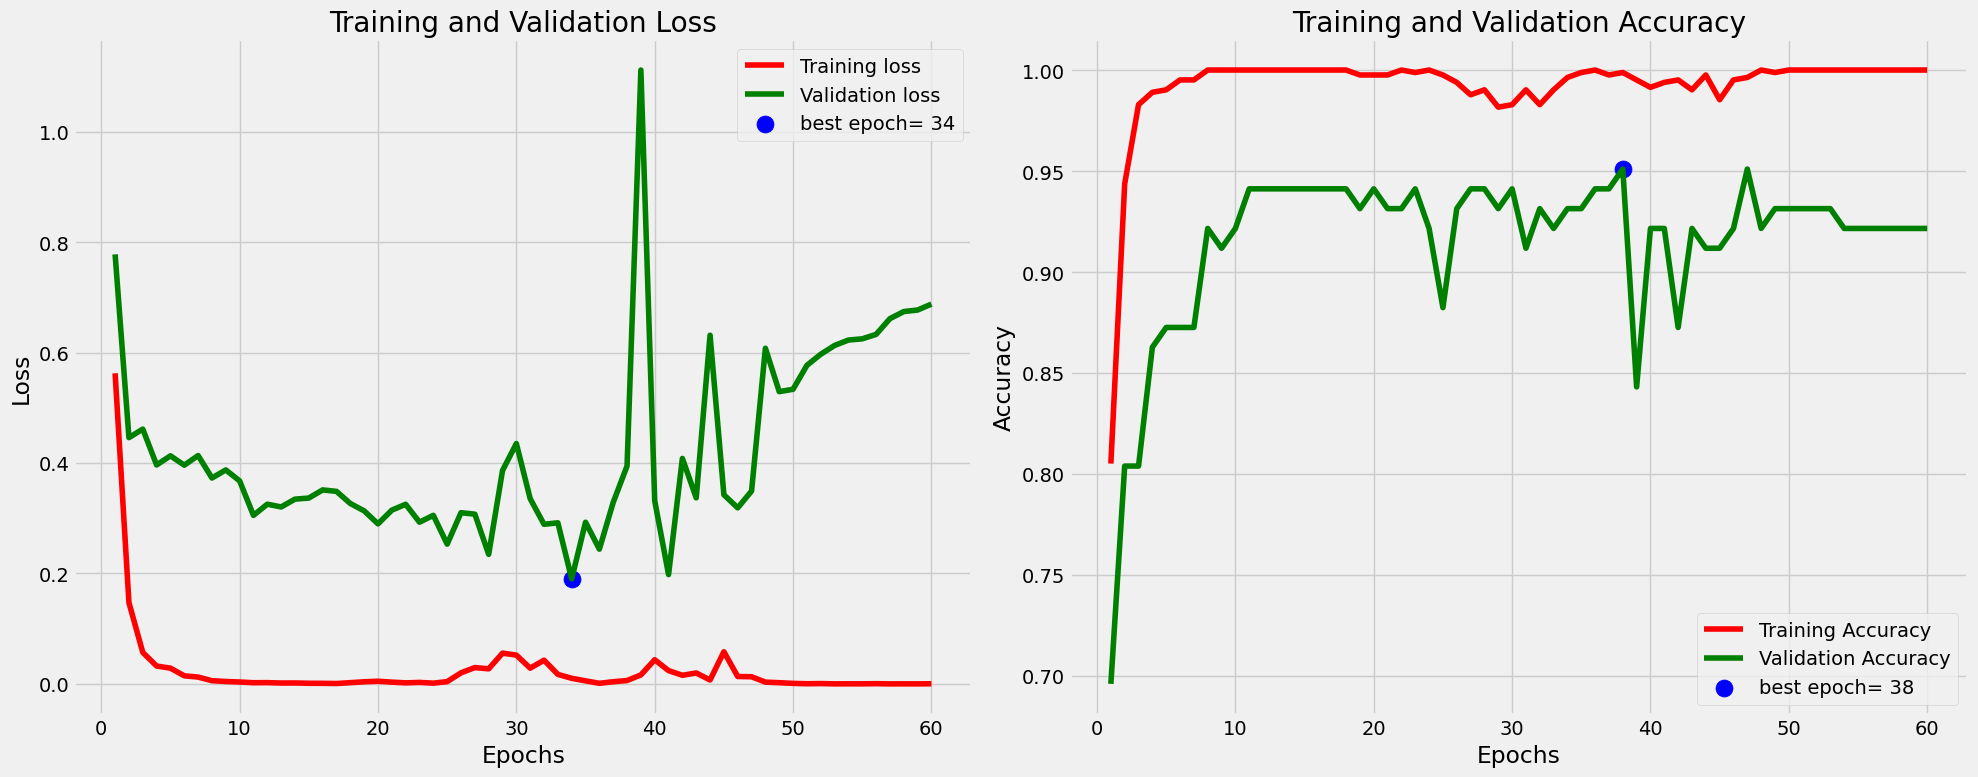

2/2 [==============================] - 1s 215ms/step - loss: 0.6667 - accuracy: 0.9314
accuracy on the test set is 93.14 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tr_plot(history, 0)
save_dir = '/content/drive/MyDrive/Model/Dense169'
subject = 'Parkinson'
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    for key, value in class_dict.items():
        new_dict[value] = key
    classes = list(new_dict.values())
    dict_as_text = str(new_dict)
    dict_name = subject + '-' + str(len(classes)) + '.txt'
    dict_path = os.path.join(save_dir, dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        if pred_index != true_index:  # Terjadi kesalahan klasifikasi
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'With accuracy of 100% there are no errors to print'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
    if errors > 0:
        # Plot jumlah kesalahan per kelas
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        plt.title('Errors by Class on Test Set')
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # Membuat confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

2/2 [==============================] - 3s 277ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

  non tremor       0.89      0.98      0.93        50
      tremor       0.98      0.88      0.93        52

    accuracy                           0.93       102
   macro avg       0.93      0.93      0.93       102
weighted avg       0.94      0.93      0.93       102



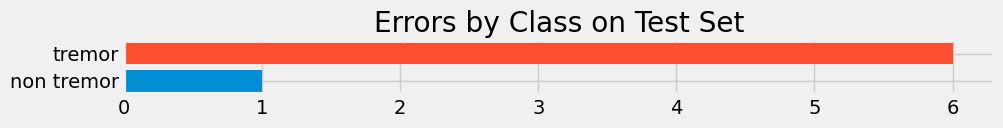

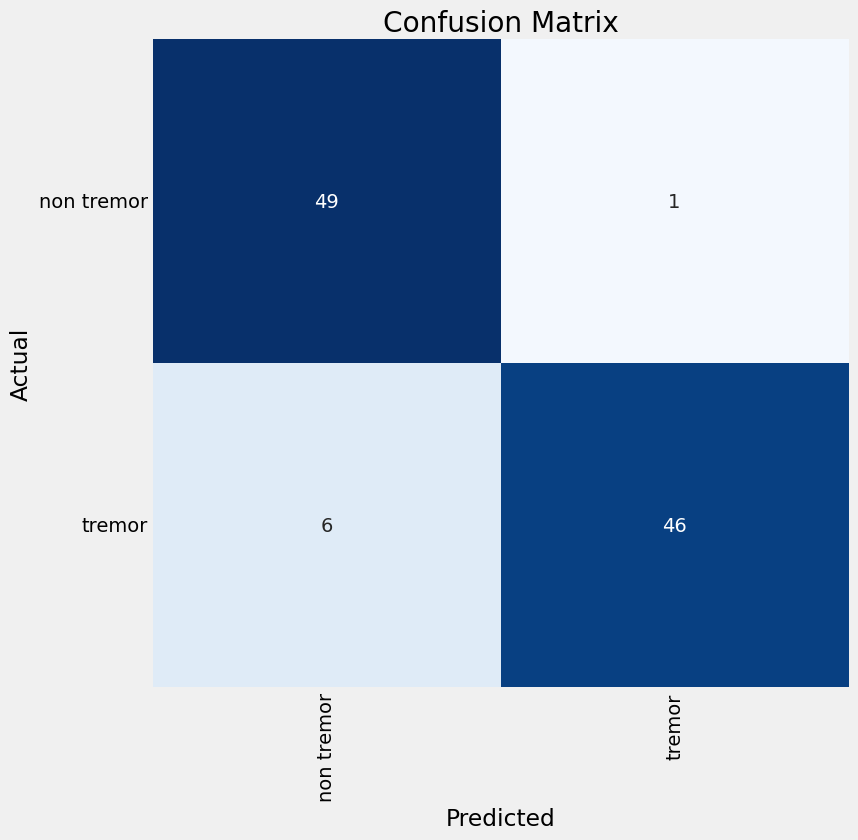

In [ ]:
print_code = 0
preds = model.predict(test_gen)
print_info(test_gen, preds, print_code, save_dir, subject)

In [ ]:
def predict_parkinson(image_path, model):
    # Memuat gambar
    image = load_img(image_path, target_size=(224, 224))

    # Konversi gambar ke array
    image_array = img_to_array(image)

    # Normalisasi nilai piksel
    image_array = image_array / 255.0

    # Mengubah dimensi array
    image_array = np.expand_dims(image_array, axis=0)

    # Melakukan prediksi
    prediction = model.predict(image_array)

    # Mendapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(prediction)

    # Melakukan mapping nama kelas
    class_names = {0: 'non tremor', 1: 'tremor'}
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Memanggil fungsi predict_parkinson
image_path = "/content/drive/MyDrive/DATASET MURNI/testing/tremor/wave/V02PO01.png"
predicted_class = predict_parkinson(image_path, model)

print("Prediction is {}.".format(predicted_class))

1/1 [==============================] - 0s 52ms/step
Prediction is tremor.
